In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

%matplotlib inline

In [2]:
dados=np.loadtxt('SCPUnion2.1_mu_vs_z.txt',usecols=[1,2,3])
z=dados[:,0]
mu_o=dados[:,1]
err_mu=dados[:,2]

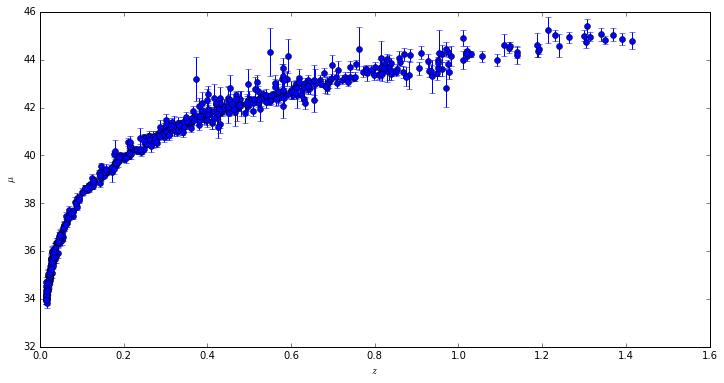

In [3]:
plt.figure(figsize = (12,6))
plt.errorbar(z,mu_o,yerr=[err_mu,err_mu],fmt='bo')
plt.ylabel(r'$\mu$')
plt.xlabel(r'$z$')
plt.show()

In [4]:
def H(z,OM,H0,w):
    if w==-1:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM))
    else:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))

c=2.99792e5

def dL(z,OM,H0,w):
    return (1+z)*quad(lambda x:c/H(x,OM,H0,w),0,z)[0]

def mu(z,OM,H0,w):
    return 5*sp.log10(dL(z,OM,H0,w))+25
    
def chi2(OM,H0,z,mu_o,sigma,w):
    mu_t=np.array([mu(zi,OM,H0,w) for zi in z])
    return sum((mu_o-mu_t)**2/sigma**2)
  
OM_var=np.arange(0,1,0.001)
w_var=np.arange(-2,0,0.01)
print(len(OM_var)*len(w_var))

200000


In [5]:
chi2_obs=np.array([chi2(OM,70,z,mu_o,err_mu,-1) for OM in OM_var])
OM_var[np.where(chi2_obs==min(chi2_obs))]

array([ 0.278])

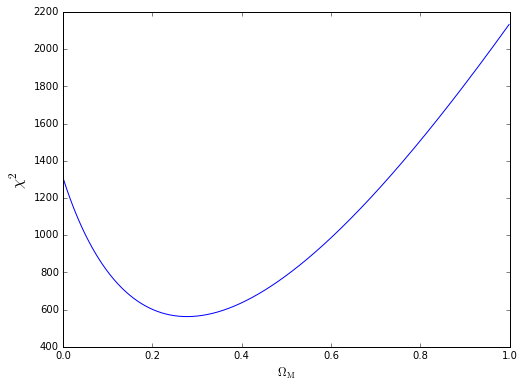

In [6]:
plt.figure(figsize = (8,6))
plt.plot(OM_var,chi2_obs)
plt.xlabel(r'$\Omega_{\rm M}$',fontsize=12)
plt.ylabel(r'$\chi^2$',fontsize=16)
plt.show()

In [7]:
norm=sp.trapz(sp.exp(-0.5*chi2_obs),OM_var)
print(norm)

2.71116244271e-124


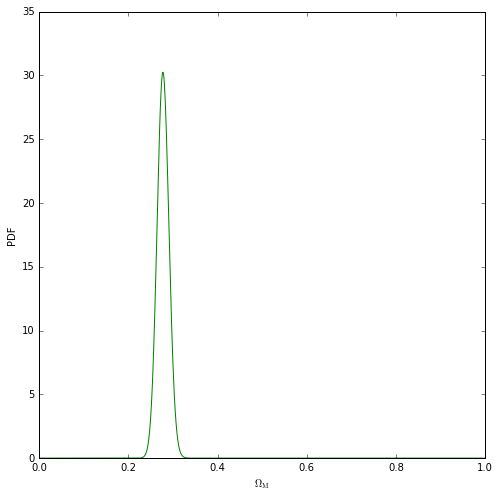

In [8]:
plt.figure(figsize = (8,8))
plt.plot(OM_var,sp.exp(-0.5*chi2_obs)/norm,'g')
#plt.xlim([0.2,0.35])
plt.xlabel(r'$\Omega_{\rm M}$',fontsize=10)
plt.ylabel('PDF',fontsize=10)
plt.show()

In [9]:
chi2_obs_w=np.array([chi2(0.31,70,z,mu_o,err_mu,w_i) for w_i in w_var])

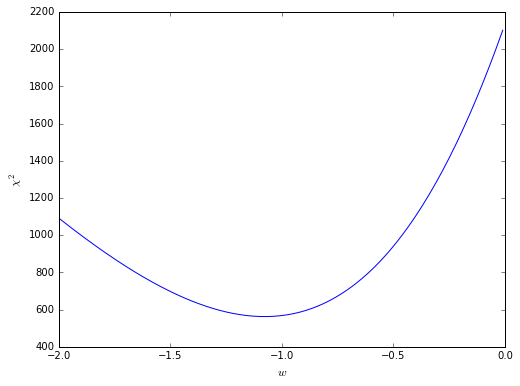

In [10]:
plt.figure(figsize = (8,6))
plt.plot(w_var,chi2_obs_w)
plt.xlabel(r'$w$',fontsize=12)
plt.ylabel(r'$\chi^2$',fontsize=12)
plt.show()

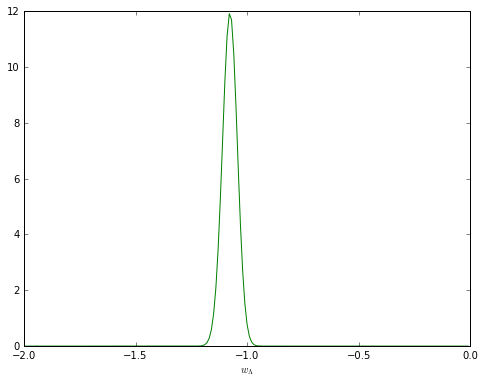

In [11]:
norm_w=sp.trapz(sp.exp(-0.5*chi2_obs_w),w_var)
plt.figure(figsize = (8,6))
plt.plot(w_var,sp.exp(-0.5*chi2_obs_w)/norm_w,'g')
plt.xlim([-2,0])
plt.xlabel(r'$w_{\Lambda}$',fontsize=10)
plt.show()

In [12]:
w_var[np.where(chi2_obs_w==min(chi2_obs_w))]

array([-1.08])

In [13]:
def prior_om(x):
    if x>=0 and x<=1:
        return 1
    else:
        return 0
    
def prior_w(x):
    if x>=-2 and x<=0:
        return 1
    else:
        return 0

In [14]:
N=40000
o_m=np.zeros(N)
w=np.zeros(N)
chi2_mcmc=np.zeros(N)
o_m[0]=np.random.rand()
w[0]=np.random.rand()*2-2
chi2_mcmc[0]=chi2(o_m[0],70,z,mu_o,err_mu,w[0])
o_m_p=o_m[0]
w_p=w[0]
chi2_p=chi2_mcmc[0]
#inter_ho=0.1
for i in range(N-1):
    o_m[i+1]=o_m_p+np.random.randn()*0.01
    w[i+1]=w_p+np.random.randn()*0.02
    chi2_mcmc[i+1]=chi2(o_m[i+1],70,z,mu_o,err_mu,w[i+1])
    if prior_om(o_m[i+1])==0:
        r=0.0
        next
    elif prior_w(w[i+1])==0:
        r=0.0
        next
    else:
        r=sp.exp(-(chi2_mcmc[i+1]-chi2_p)/2)#*prior_om(o_m[i+1])/prior_om(o_m[i])*prior_w(w[i+1])/prior_w(w[i])
    teste=np.random.rand()
    if r>teste:
        o_m_p=o_m[i+1]
        w_p=w[i+1]
        chi2_p=chi2_mcmc[i+1]
    #print(r)


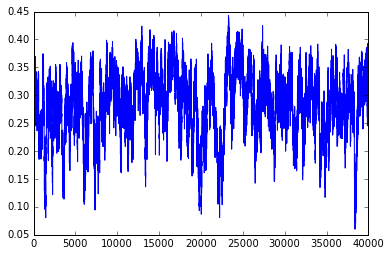

In [15]:
plt.plot(o_m)
plt.show()

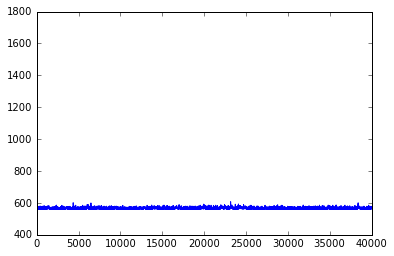

In [16]:
plt.plot(chi2_mcmc)
plt.show()

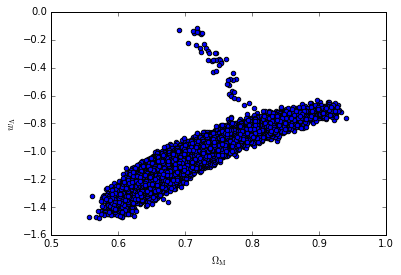

In [17]:
plt.scatter(1-o_m[0:-1],w[0:-1])
plt.xlabel(r'$\Omega_{\rm M}$')
plt.ylabel(r'$w_{\Lambda}$')
plt.show()

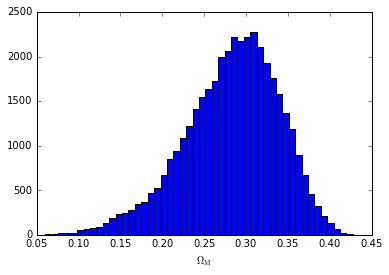

In [18]:
plt.hist(o_m,bins=50)
plt.xlabel(r'$\Omega_{\rm M}$')
plt.show()

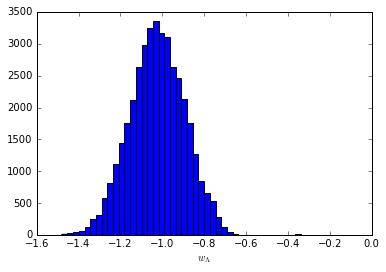

In [19]:
plt.hist(w,bins=50)
plt.xlabel(r'$w_{\Lambda}$')
plt.show()

In [20]:
chi_min=np.amin(chi2_mcmc)
deltachi2=chi2_mcmc-chi_min
deltachi2_grid = griddata((o_m,w), deltachi2, (OM_var[None,:], w_var[:,None]), method='cubic')


In [21]:
import matplotlib as mpl
colors = [(0.0, 0.0, 0.0, 0.7),(0.0, 0.0, 0.0, 0.4)] #black different alphas
cmap = mpl.colors.ListedColormap(colors)

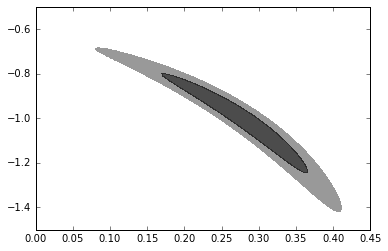

In [22]:

levels=np.array([0,2.30,6.17])
CS=plt.contourf(OM_var,w_var, deltachi2_grid,levels=levels, cmap=cmap)
plt.xlim([0.0,0.45])
plt.ylim([-1.5,-0.5])
plt.show()

In [23]:
# Now redo everything  for a data with a wrong redshift
# as an example the error in redshift comes from  missing the correct galaxy. 
# to porduce a new redshift we draw from a gaussian with sigma_z=0.2 centered at the old value
# I'll will assume that 9% of the SNe1a actually have their redshift wrong
z_b=np.zeros(len(z))
error_z=0.1
for i in range(len(z)):
    pvalue=np.random.rand()
    if pvalue>0.09:
        z_b[i]=z[i]
    else:
        z_b[i]=z[i]+np.random.randn()*error_z
        while z_b[i]<=0:
            z_b[i]=z[i]+np.random.randn()*error_z

        

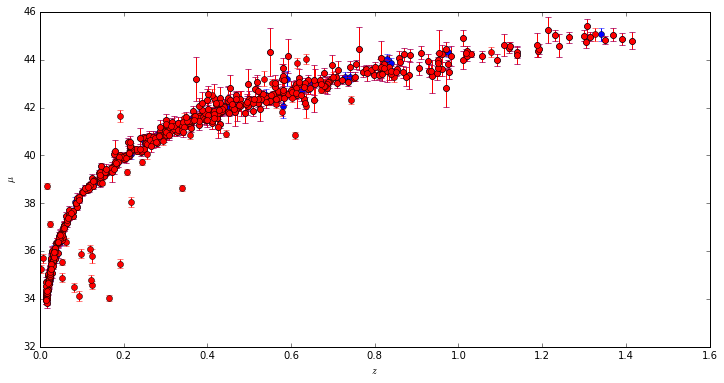

In [24]:
plt.figure(figsize = (12,6))
plt.errorbar(z,mu_o,yerr=[err_mu,err_mu],fmt='bo')
plt.errorbar(z_b,mu_o,yerr=[err_mu,err_mu],fmt='ro')
plt.ylabel(r'$\mu$')
plt.xlabel(r'$z$')
plt.show()

In [25]:
N=40000
o_m_b=np.zeros(N)
w_b=np.zeros(N)
chi2_mcmc_b=np.zeros(N)
o_m_b[0]=np.random.rand()
w_b[0]=np.random.rand()*2-2
chi2_mcmc_b[0]=chi2(o_m_b[0],70,z_b,mu_o,err_mu,w_b[0])
o_m_p_b=o_m_b[0]
w_p_b=w_b[0]
chi2_p=chi2_mcmc_b[0]
for i in range(N-1):
    o_m_b[i+1]=o_m_p_b+np.random.randn()*0.01
    w_b[i+1]=w_p_b+np.random.randn()*0.02
    chi2_mcmc_b[i+1]=chi2(o_m_b[i+1],70,z_b,mu_o,err_mu,w_b[i+1])
    if prior_om(o_m_b[i+1])==0 or prior_w(w_b[i+1])==0:
        r=0.0
        next
    else:
        r=sp.exp(-(chi2_mcmc_b[i+1]-chi2_p)/2)#*prior_om(o_m_b[i+1])/prior_om(o_m_p_b)*prior_w(w_b[i+1])/prior_w(w_p_b)
    teste=np.random.rand()
    if r>teste:
        o_m_p_b=o_m_b[i+1]
        w_p_b=w_b[i+1]
        chi2_p=chi2_mcmc_b[i+1]
    #else:
    #    o_m_p_b=o_m_b[i]
    #    w_p_b=w_b[i]
    #    chi2_mcmc_b[i+1]=chi2_mcmc_b[i]
    #print(N-i)



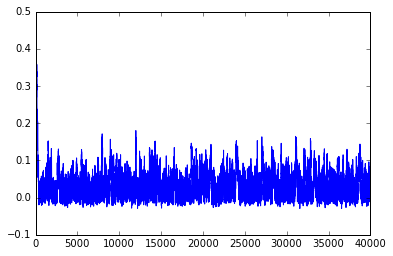

In [26]:
plt.plot(o_m_b)

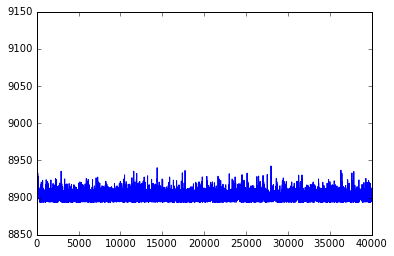

In [27]:
plt.plot(chi2_mcmc_b)

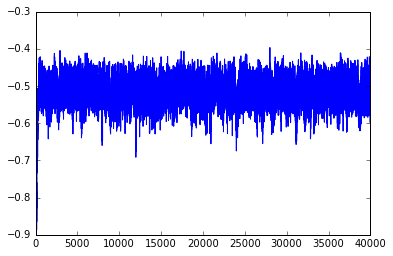

In [28]:
plt.plot(w_b)

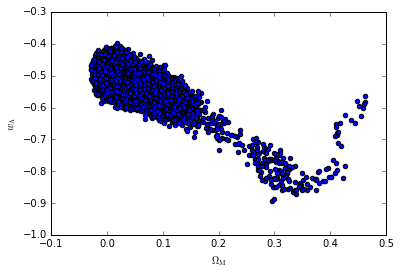

In [29]:
plt.scatter(o_m_b,w_b)
plt.xlabel(r'$\Omega_{\rm M}$')
plt.ylabel(r'$w_{\Lambda}$')
plt.show()

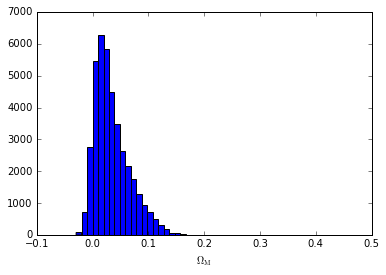

In [30]:
plt.hist(o_m_b,bins=50)
plt.xlabel(r'$\Omega_{\rm M}$')
plt.show()

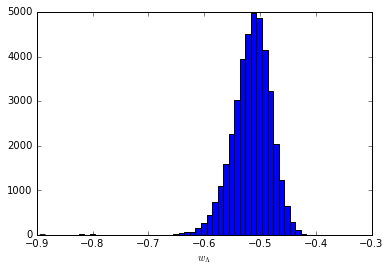

In [31]:
plt.hist(w_b,bins=50)
plt.xlabel(r'$w_{\Lambda}$')
plt.show()

In [32]:
chi_min_b=np.amin(chi2_mcmc_b)
deltachi2_b=chi2_mcmc_b-chi_min_b
deltachi2_grid_b = griddata((o_m_b,w_b), deltachi2_b, (OM_var[None,:], w_var[:,None]), method='cubic')



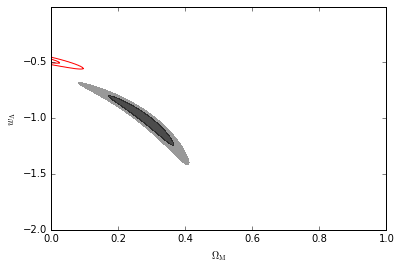

In [33]:
levels=np.array([0,2.30,6.17])
CS=plt.contourf(OM_var,w_var, deltachi2_grid,levels=levels, cmap=cmap)
CS2=plt.contour(OM_var,w_var, deltachi2_grid_b,levels=levels,colors='r')# cmap=plt.cm.get_cmap('Blues'))

#plt.xlim([0.20,0.4])
#plt.ylim([68,72])
plt.xlabel(r'$\Omega_{\rm M}$')
plt.ylabel(r'$w_{\Lambda}$')
plt.savefig('bias_contour_om_w.pdf')
plt.show()
